In [1]:
from graph_tool.all import Graph, graph_draw
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import animation
from seaborn import heatmap, color_palette
from scipy import sparse

import nbimporter


# Utility Functions

In [2]:
def show_matrice(W):
    %matplotlib inline
    fig = plt.figure(figsize=(9,7))
    map = heatmap(W.todense(), cmap=color_palette("vlag", as_cmap=True))

In [3]:
from graph_tool.all import arf_layout,  value_types, get_hierarchy_tree, radial_tree_layout, get_hierarchy_control_points, minimize_nested_blockmodel_dl
import matplotlib
from math import sqrt

def draw_network(W, Wout = None, Win = None):
    row, col= W.row, W.col
    W = W.toarray()/np.amax(W)
    n = len(W)
    
    # We add the edges
    edge_index = []
    pen_width = []
    for i in range(len(col)):
        edge_index.append((row[i], col[i]))
        pen_width.append(W[row[i]][col[i]])

    if Win is not None:
        for i in range(len(Win)):
            edge_index.append((n+1, i))
            pen_width.append(Win[i]/np.amax(Win))

    if Wout is not None:
        for i in range(len(Wout)):
            edge_index.append((i, n))
            pen_width.append(Wout[i]/np.amax(Wout))

    edge_index = np.array(edge_index)
    g = Graph(directed=True)
    g.add_edge_list(edge_index)
    
    edge_pen_width  =  g.new_edge_property("double")
    edge_pen_width.a = np.abs(pen_width)*4

    vertex_color = []
    vertex_text = []
#     color = g.new_vp("double")
    text = g.new_vp("double")
    for v in g.vertex_index:
#         vertex_color.append(Win[v])
        vertex_text.append(v)
#     color.a = vertex_color
    text.a = vertex_text
    pos = arf_layout(g)
    pos[n] = [7, 4]
    pos[n+1] = [1, 4]
 
    # The curvatures of the edges
    state = minimize_nested_blockmodel_dl(g)
    t = get_hierarchy_tree(state)[0]
    tpos = radial_tree_layout(t, t.vertex(t.num_vertices() - 1), weighted=True)
    cts = get_hierarchy_control_points(g, t, tpos)

        
    graph_draw(g, pos=pos, output_size=(1000, 1000), edge_control_points=cts, 
               edge_pen_width = edge_pen_width, vertex_size=10, vertex_text = text,
               vcmap=matplotlib.cm.inferno)


# Measurement

## Richness in reservoir
https://arxiv.org/pdf/1903.05174.pdf

In [4]:
def uncoupled_dynamics(W, Win, bias, state, U_test1, leaky_rate = 1, temp = 5000, A= 0.9):
    ST = []
    if state is None:
        state = np.random.uniform(-1, 1, n)
        
    for i in range(temp):
        ST.append(state)
        u = U_test1[i]
        state = update_reservoir(W, Win, u, state, leaky_rate, bias, activation_function)

    ST = np.array(ST)

    _, S, _ = np.linalg.svd(ST)
    R = []
    for s in S:
        R.append(s / np.sum(S))

    UD = 0
    frac = 0
    while frac < A:
        frac = frac + R[UD]
        UD+=1
    return UD, frac

# Reservoir functions

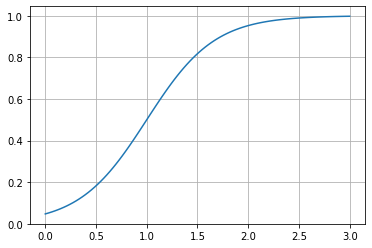

In [5]:
from importlib import reload
import reservoir.reservoir

from reservoir.reservoir import update_reservoir, ridge_regression, train, run
from reservoir.reservoir import init_matrices
from reservoir.reservoir import synaptic_scaling, activation_target_definition, constant_synaptic_scaling
from reservoir.activation_functions import tanh, heaviside, sigmoid

reload(reservoir.reservoir)

# SEED
SEED = 3789

# the activation function choosen for the rest of the experiment

activation_function = lambda x : sigmoid(3*x-3)

plt.plot(np.linspace(0, 3, 100), activation_function(np.linspace(0, 3, 100)))
plt.grid()

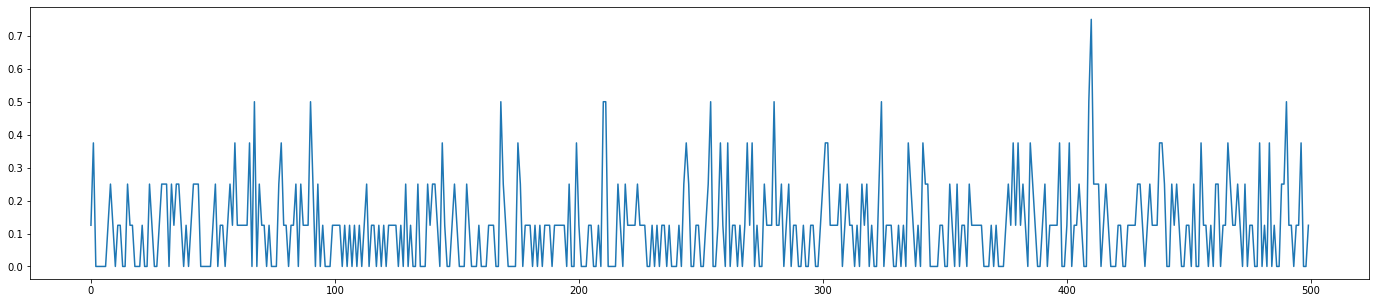

In [6]:
from scipy.stats import poisson

mu = 1
timesteps = 50000

U = poisson.rvs(mu, size=timesteps, random_state = SEED)[np.newaxis].T

# rescale between 0 and 1
U_train1 = (U - U.min()) / (U.max() - U.min())

plt.figure(figsize=(24,5))
plt.plot(range(500), U_train1[:500])
plt.show()

# Activity dependant connexion
https://www.nature.com/articles/s41598-018-22077-3#Fig1

In [7]:
from importlib import reload
import connexion_generation.activity_dependant_connexion
from connexion_generation.activity_dependant_connexion import compute_synaptic_change, add_activity_connexion
reload(connexion_generation.activity_dependant_connexion)

<module 'connexion_generation.activity_dependant_connexion' from '/home/idlab278/Code/structural_plasticity/adsp/connexion_generation/activity_dependant_connexion.py'>

## Simulation

In [8]:
def count_incoming_connexions(W):
    incoming_connexion = W.nonzero()[0]
    incoming_connexion_count = np.zeros(W.shape[0])
    for i in incoming_connexion:
        incoming_connexion_count[i] +=1
    return incoming_connexion_count

In [11]:
# Parameters
n_ee = 50 # number of neurons for excitatory pool
n_ii = 20 # number of neurons for inhibitory pool
SEED = 3789
leaky_rate = 1
input_scaling = 1

spectral_radius = 1.45
input_connectivity =  0.745
connectivity = 0.075

# HPERPARAMETERS
INCREMENT = 20
VALUE = 0.1
bias_scaling = 1


# Initialisation EE
Win_ee, W_ee, bias_ee =  init_matrices(n, input_connectivity, connectivity, spectral_radius, input_scaling, SEED)
bias_ee = bias_ee*bias_scaling
Win_ee = Win_ee*input_scaling

# Initialisation EI
Win_ei, W_ei, bias_ei =  init_matrices(n, input_connectivity, connectivity, spectral_radius, input_scaling, SEED)
bias_ei = bias_ei*bias_scaling
Win_ei = Win_ei*input_scaling

# Initialisation IE
Win_ie, W_ie, bias_ie =  init_matrices(n, input_connectivity, connectivity, spectral_radius, input_scaling, SEED)
bias_ie = bias_ie*bias_scaling
Win_ie = Win_ie*input_scaling

# last_state
last_state = np.random.uniform(0, 1, n)